# Supervised outlier detection

In [1]:
import drama as drm
import numpy as np
import random
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score
from matplotlib import gridspec
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA,TruncatedSVD,NMF,FastICA

%matplotlib inline

## Defining clustering algorithm as clustering fucntion

In [2]:
agg = AgglomerativeClustering()
metrics = drm.all_metrics

## Signal synthesis

In [3]:
n_ftrs = 100
noise = 0.25
scl = 0.02
sft = 0.02

sig_list = np.arange(1,11)
random.shuffle(sig_list)

maj_class = 100
min_class = 10

n_data = 4*[maj_class]+6*[min_class]

train_data = {sig_list[i]:n_data[i] for i in range(8)}
test_data = {sig_list[i]:n_data[i] for i in range(10)}

X_train, y_train, X, y = drm.synt_unbalanced(train_data = train_data,test_data = test_data,
                                    sigma = noise, n_ftrs = n_ftrs)

X_train, y_train_c = drm.simulate_shapes(numbers=train_data,n_ftrs = n_ftrs,
                            sigma=noise,
                            n1 = scl,n2 = sft,
                            n3 = scl,n4 = sft)

X_test,y_test_c = drm.simulate_shapes(numbers=test_data,n_ftrs = n_ftrs,
                            sigma=noise,
                            n1 = scl,n2 = sft,
                            n3 = scl,n4 = sft)

y_train = y_train_c-y_train_c
y_test = np.isin(y_test_c, sig_list[-2:]).astype(int)

true_outliers = np.in1d(y_test_c,sig_list[:7])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(440, 100) (440,) (460, 100) (460,)


## Inliers (train set)

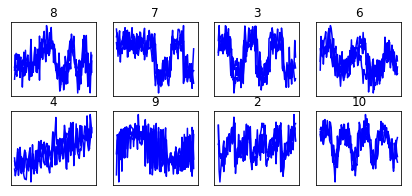

In [4]:
gs = gridspec.GridSpec(2, 4)
plt.figure(figsize=(7,3)) 

for i in range(8):
    ax = plt.subplot(gs[i%2, i//2])
    ax.set_title(str(sig_list[i]))
    ax.set_xticks([])
    ax.set_yticks([])
    for j in range(3):
        xx = X_train[y_train_c==sig_list[i]][j]
        ax.plot(xx,'b')

## Inliers and outliers (test set)

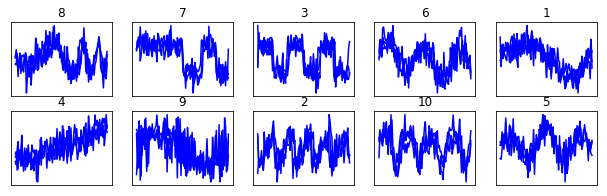

In [5]:
gs = gridspec.GridSpec(2, 5)
plt.figure(figsize=(10.5,3)) 

for i in range(10):
    ax = plt.subplot(gs[i%2, i//2])
    ax.set_title(str(sig_list[i]))
    ax.set_xticks([])
    ax.set_yticks([])
    for j in range(3):
        xx = X_test[y_test_c==sig_list[i]][j]
        ax.plot(xx,'b')

In [6]:
d_drama = drm.D_Drama(X_seen=X_train,drt_name='FastICA',z_dim=2)

In [7]:
d_drama.splitter.split(1,verbose=0,training_epochs=20)

In [8]:
drts = 'AE','VAE','PCA','NMF','FastICA'
for drt in drts:
    d_drama = drm.D_Drama(X_seen=X_train,drt_name=drt,z_dim=2)
    d_drama.splitter.split(3,verbose=0,training_epochs=20)

    mcomps = np.reshape(d_drama.splitter.mean_components[2],(-1,100))
    print(mcomps.shape)

    for i in mcomps:
        plt.plot(i)
    plt.ylim(-0.3,1.5)
    plt.savefig(drt+'.jpg')
    plt.close()

(8, 100)
(8, 100)
(8, 100)
(8, 100)
(8, 100)


In [9]:
res = d_drama(X_unseen=X_test,n_split=1)

/home/gf/packages/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [10]:
res['real']['mahalanobis'].shape

(460,)

In [11]:
dd = drm.grid_run_drama(X_seen=X_train,y_seen=y_train,
                 X_unseen=X_test,y_unseen=y_test, n_split=3)

Novelty detection mode.


In [12]:
drts = 'AE','VAE','PCA','NMF','FastICA'
drt = drts[0]
nsplit = 3

for i in range(5):
    for j in range(2,3):
        xx = dd[0][(dd[3][:,1]==drts[i]) & (dd[3][:,3]==str(j+1))].mean()
        print('{:10s} {} : {}'.format(drts[i],j+1,xx))
        
print(dd[0].mean())
print(dd[0][dd[3][:,3]=='3'].mean())

AE         3 : 0.41275000000000006
VAE        3 : 0.4352045454545455
PCA        3 : 0.48769318181818183
NMF        3 : 0.5367613636363637
FastICA    3 : 0.5066818181818181
0.4869954545454545
0.4758181818181818


In [76]:
dd = drm.grid_run_lof(X_seen=X_train,y_seen=y_train,
                 X_unseen=X_test,y_unseen=y_test)
dd[0].mean()

Novelty detection mode.


0.810110544217687

In [15]:
dd = drm.grid_run_iforest(X_seen=X_train,y_seen=y_train,
                 X_unseen=X_test,y_unseen=y_test)
dd[0].mean()

Novelty detection mode.


0.9367803030303029

In [74]:
dd = drm.grid_run_drama(X_seen=X_train,y_seen=y_train,
                 X_unseen=X_test,y_unseen=y_test, n_split=3)
dd[0].mean()

Novelty detection mode.


0.9075446969696971

In [12]:
# These fucntions are defined according to the configuration of this synthetic data.
#(Some parts should be changes if you want to use other configuration of data.)

def conv2true(inds):
    t_ind = []
    diff = np.setdiff1d(inds,np.arange(4*maj_class+4*min_class,4*maj_class+6*min_class))
    j = 0
    for i in range(4*maj_class+4*min_class,4*maj_class+6*min_class):
        if i in inds:
            t_ind.append(i)
        else:
            t_ind.append(diff[j])
            j += 1
    return np.array(t_ind)

# def post_cluster_error(X,outliers,true_outliers):
#     n_out = true_outliers.sum()
#     inds = np.argsort(outliers)[:-n_out-1:-1]
#     inds = conv2true(inds)
#     X_outliers = X[inds]    
#     splitter = mce.Splitter(X_outliers, PCA(n_components=2),
#                                 clustering=agg.fit_predict)

#     splitter.split(1,verbose=0,training_epochs=20)
#     labels = splitter.labels[-1]

#     error = 0
#     unique, counts = np.unique(labels, return_counts=True)
#     for label,num in zip(unique, counts): 
#         max_occ = -1
#         for i in range(0,2*min_class,min_class):
#             occ = (labels[i:i+min_class]==label).sum()
#             if occ>max_occ:
#                 max_occ = occ
#                 aa = 4*maj_class+4*min_class
#                 [aa+i:aa+i+min_class]==label
#         error += np.absolute(max_occ-num)/(2.*min_class)
#     return error

def post_cluster_precision(X,outliers,true_outliers):
    
    n_out = true_outliers.sum()
    inds = np.argsort(outliers)[:-n_out-1:-1]
    inds = conv2true(inds)
    X_outliers = X[inds]

    splitter = drm.Splitter(X_outliers, PCA(n_components=2),
                                clustering=agg.fit_predict)
    splitter.split(1,verbose=0,training_epochs=20)
    labels = splitter.labels[-1]
    
    true_inds = np.argwhere(true_outliers).reshape(-1)
    precision = 0
    for i in np.unique(labels):
        max_occ = -1
        for j in range(2):
            occ = np.in1d(inds[labels==i],true_inds[j*min_class:(j+1)*min_class]).sum()
            if occ>max_occ:
                max_occ = occ
        precision += max_occ/100.
    return precision

from time import time
def full_test_supervised_post_cluster(X_train,X_test,y_test,j,levs,o_list,z_dim=2):
    dim_rs ={'AE':'AE','VAE':'VAE','none':'none','PCA':PCA(n_components=z_dim),'NMF':NMF(n_components=2), 
             'FastICA':FastICA(n_components=2, max_iter=1000)}

    dr_name = ['AE','VAE','none','PCA','NMF','FastICA']
    dr_f = ['AE','VAE','none',PCA(n_components=z_dim),
            NMF(n_components=z_dim),FastICA(n_components=z_dim, max_iter=1000)]

    dim_rs ={dr_name[j]:dr_f[j]}
    # dim_rs ={'none':'none'}
    metrics = drm.all_metrics

    # metrics = ['mahalanobis']

    columns = ['DRT','level','Metric','detspace']+['AUC','MCC','BRU','c_prec']
    n_row = levs*len(dim_rs)*(len(metrics)+1)
    index = np.arange(n_row) # array of numbers for the number of samples
    df = pd.DataFrame(columns=columns, index = index)

    exec ('T_o ='+(' | '.join(['(y_test=='+str(i)+')' for i in o_list])),locals(),globals())

    i = -1
    for dim_r, value in dim_rs.items():

        print ('---------------  '+dim_r+'  ----------------')
        for lev in range(levs):
            # Splitter definition
            splitter = drm.Splitter(X_train, reducer = value, clustering = agg.fit_predict, z_dim=z_dim)

            # Splitting
            splitter.split(1,verbose=0,training_epochs=20)

            # outlier extraction for all of requeste metrics
            outliers_r = drm.outliers_real(X_test,splitter,metrics)

            for metr in metrics:

                i += 1
                df['DRT'][i] = dim_r
                df['level'][i] = lev+1
                df['Metric'][i] = metr
                df['detspace'][i] = 'real'
                df['AUC'][i] = roc_auc_score(T_o, outliers_r[metr])
                df['MCC'][i] = drm.MCC(T_o, outliers_r[metr])
                df['BRU'][i] = drm.rws_score(T_o, outliers_r[metr])
                df['c_prec'][i] = post_cluster_precision(X_test,outliers_r[metr],T_o)

            i += 1
            df['DRT'][i] = dim_r
            df['level'][i] = lev+1
            df['Metric'][i] = 'ens'
            df['detspace'][i] = 'real'  
            ens_out = drm.norm_ensemble(outliers_r,0.1)
            df['AUC'][i] = roc_auc_score(T_o, ens_out)
            df['MCC'][i] = drm.MCC(T_o, ens_out)
            df['BRU'][i] = drm.rws_score(T_o, ens_out)
            df['c_prec'][i] = post_cluster_precision(X_test,ens_out,T_o)

        t1 = time()
        
    return df,t1-t0

In [13]:
X_train, y_train, X, y = drm.synt_unbalanced(train_data = train_data,test_data = test_data,
                                    sigma = noise, n_ftrs = n_ftrs)

true_outliers = np.in1d(y,sig_list[8:])

In [17]:
j = 1
levs = 7
o_list = sig_list[8:]

df,dt = full_test_supervised_post_cluster(X_train,X,y,j,levs,o_list,z_dim=2)

---------------  VAE  ----------------
dict_items([('VAE', 'VAE')])


In [18]:
df

,DRT,level,Metric,detspace,AUC,MCC,BRU,c_prec
0,VAE,1,cityblock,real,0.998809,0.885,0.797822,0.89
1,VAE,1,L2,real,0.998709,0.895455,0.82495,0.9
2,VAE,1,L4,real,0.9919,0.790909,0.734257,0.8
3,VAE,1,braycurtis,real,0.946018,0.456364,0.314653,0.48
4,VAE,1,canberra,real,0.85365,0.257727,0.208515,0.29
5,VAE,1,chebyshev,real,0.906964,0.341364,0.394257,0.2
6,VAE,1,correlation,real,0.956409,0.393636,0.409505,0.42
7,VAE,1,mahalanobis,real,1,1,1,1
8,VAE,1,wL2,real,0.999991,0.989545,0.980198,0.99
9,VAE,1,wL4,real,0.999986,0.989545,0.980594,0.99


## Outlier detection using autoencoders

In [42]:
dim_rs ={'AE':'AE','VAE':'VAE','none':'none','PCA':PCA(n_components=2),
         'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}
dim_rs ={'FastICA':FastICA(n_components=2, max_iter=1000)}
# dim_rs ={'VAE':'VAE'}

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Splitter(X_train, value,clustering=agg.fit_predict)
    
    # Splitting
    splitter.split(3,verbose=0,training_epochs=20)
        
    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
    
    for metr in metrics:
        print metr,mce.bru_score(true_outliers, outliers[metr])
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = mce.bru_score(true_outliers, ems_outliers)
    print auc

    error = post_cluster_error(X,ems_outliers,true_outliers)
    print '{}: error={:4.2f}'.format(dim_r,error)
        
    print '*********************************************'

---------------  FastICA  ----------------
cityblock 0.633069306931
L2 0.475643564356
L4 0.333465346535
braycurtis 0.761188118812
canberra 0.0
chebyshev 0.230099009901
correlation 1.0
mahalanobis 0.51801980198
wL2 0.941782178218
wL4 0.893069306931
0.922178217822
FastICA: error=0.00
*********************************************


In [70]:
n_out = true_outliers.sum()
inds = np.argsort(ems_outliers)[:-n_out-1:-1]
inds = conv2true(inds)
X_outliers = X[inds]

splitter = mce.Splitter(X_outliers, PCA(n_components=2),
                            clustering=agg.fit_predict)

splitter.split(1,verbose=0,training_epochs=20)
labels = splitter.labels[-1]

In [60]:
error = 0
inds == np.argwhere(true_outliers).reshape(-1)
inds
# np.argwhere(true_outliers).reshape(-1)
# unique, counts = np.unique(labels, return_counts=True)
# for label,num in zip(unique, counts): 
#     max_occ = -1
#     for i in range(0,2*min_class,min_class):
#         occ = (labels[i:i+min_class]==label).sum()
#         if occ>max_occ:
#             max_occ = occ
#             aa = 4*maj_class+4*min_class
#             [aa+i:aa+i+min_class]==label
#     error += np.absolute(max_occ-num)/(2.*min_class)
    
# print error

array([  50,   51,   52,   53,   54,   55,   56,   58,   59,   61,   62,
         63,   64,   65,   66,   67,   68,   69,   70,   71,   72,   73,
         74,   75,   76,   77,   78,   79,   80,   81,   82,   83,   84,
         85,   87,   88,   89,   90,   91,   92,   93,   94,   95,   96,
         97,   99, 1854, 2011, 2051, 2169, 2250, 2251, 2252, 2253, 2254,
       2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265,
       2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276,
       2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287,
       2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298,
       2299])

## Outlier detection using Scikit-learn dimensionality reduction classes

In [84]:
sk_check(X_train,X,y,[8,9,10])

,method,AUC,MCC,BRU
0,LOF35,0.377277,-0.161275,0.153067
1,i-forest,0.898726,0.639216,0.783222


In [23]:
import pandas as pd
from sklearn import neighbors 
from sklearn.ensemble import IsolationForest
def sk_check(X_train,X_test,y_test,o_list):
    f_f = [neighbors.LocalOutlierFactor(n_neighbors=5),\
    neighbors.LocalOutlierFactor(n_neighbors=10),\
    neighbors.LocalOutlierFactor(n_neighbors=35),\
    IsolationForest(max_samples='auto')]
    f_name = ['LOF5','LOF10','LOF35','i-forest']

    columns = ['method']+['AUC','MCC','BRU']
    n_row = 2
    index = np.arange(n_row) # array of numbers for the number of samples
    df = pd.DataFrame(columns=columns, index = index)

    exec 'T_o ='+(' | '.join(['(y_test=='+str(i)+')' for i in o_list]))

    auc_max = -1
    for i in range(3):
        lof = f_f[i]
        lof.fit(X_test)
        outliers = -lof.negative_outlier_factor_

        auc_test = roc_auc_score(T_o, outliers)
        if auc_test>auc_max:
            auc_max = auc_test
            df['method'][0] = f_name[i]
            df['MCC'][0] = mce.MCC(T_o, outliers)
            df['AUC'][0] = auc_max
            df['BRU'][0] = mce.bru_score(T_o, outliers)

    df['method'][1] = f_name[3]
    isof = f_f[3]
    isof.fit(X_train)
    scores_pred = isof.decision_function(X_test)
    outliers = scores_pred.max()-scores_pred
    df['MCC'][1] = mce.MCC(T_o, outliers)
    df['AUC'][1] = roc_auc_score(T_o, outliers)
    df['BRU'][1] = mce.bru_score(T_o, outliers)

    return df

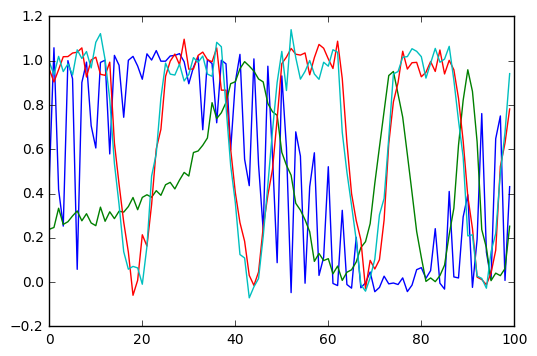

In [143]:
for i in splitter.mean_components[-1].reshape(-1,n_ftrs):
    plt.plot(i)